# Ronit Kumar Kataria

# Regression Tasks on Sample Data of AIFactor.CA

In [1]:
!pip install optuna
!pip install catboost
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00


In [2]:
# All Modules to be imported first

import pandas as pd
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import optuna
from pylab import rcParams
import catboost as cb
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error


In [4]:
data = pd.read_excel('sample_data.xlsx')


# Data Pre-Processing

In [5]:

for col in data.columns:
    if col == 'Date/Time' or col == 'target':
        continue
    else:
        temp = 'sensor' + str(col)
        data = data.rename(columns={col:temp})

<h3> Removing the Outliers from Data </h3>

In [6]:
# target = data['target']
# z_scores = np.abs((target - np.mean(target)) / np.std(target))
# threshold = 3
# filtered_target = target[(z_scores <= threshold) & (~np.isnan(z_scores))]
# data['target'] = filtered_target


In [7]:
# Data without Date/Time
from sklearn.preprocessing import StandardScaler
data_without_date = data.drop(['Date/Time'], axis=1)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data
scaled_data = scaler.fit_transform(data_without_date)

# Convert the scaled_data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data_without_date.columns)


# EDA

In [8]:
statistics = data.describe()
print(statistics)


       target  sensor1  sensor2  sensor3  sensor4  sensor5  sensor6  sensor7  \
count 1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00  1440.00   
mean     0.14   876.36   340.03  2550.02    28.48   124.29   117.86   124.50   
std      0.01     1.08     3.25     5.83     0.06     0.27     0.08     0.11   
min      0.10   873.18   330.16  2525.86    28.26   123.54   117.70   124.26   
25%      0.13   875.61   337.65  2546.21    28.44   124.13   117.80   124.41   
50%      0.13   876.33   340.23  2549.99    28.48   124.31   117.87   124.49   
75%      0.14   877.11   342.31  2554.05    28.53   124.45   117.92   124.59   
max      0.16   880.00   400.32  2570.37    28.64   125.21   118.24   124.85   

       sensor8  sensor9  ...  sensor26  sensor27  sensor28  sensor29  \
count  1440.00  1440.00  ...   1440.00   1440.00   1440.00   1440.00   
mean    115.19   108.37  ...     68.07     62.20     68.07    -30.35   
std       0.08     0.27  ...      0.36      0.42      0.00     

In [9]:
statistics['target']['mean']


0.13549159136602024

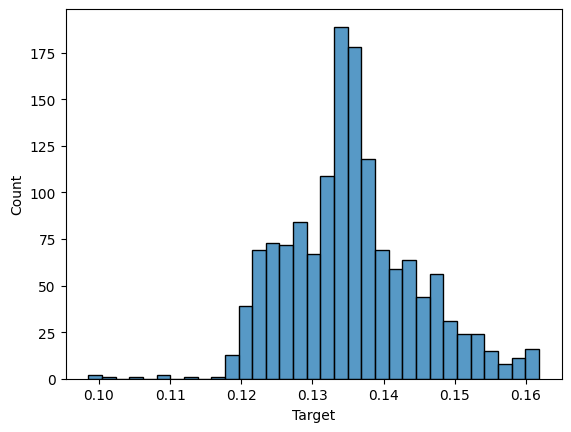

In [10]:
ax = sns.histplot(data=data, x='target', kde=False)
ax.set_xlabel('Target')
ax.set_ylabel('Count')

plt.show()


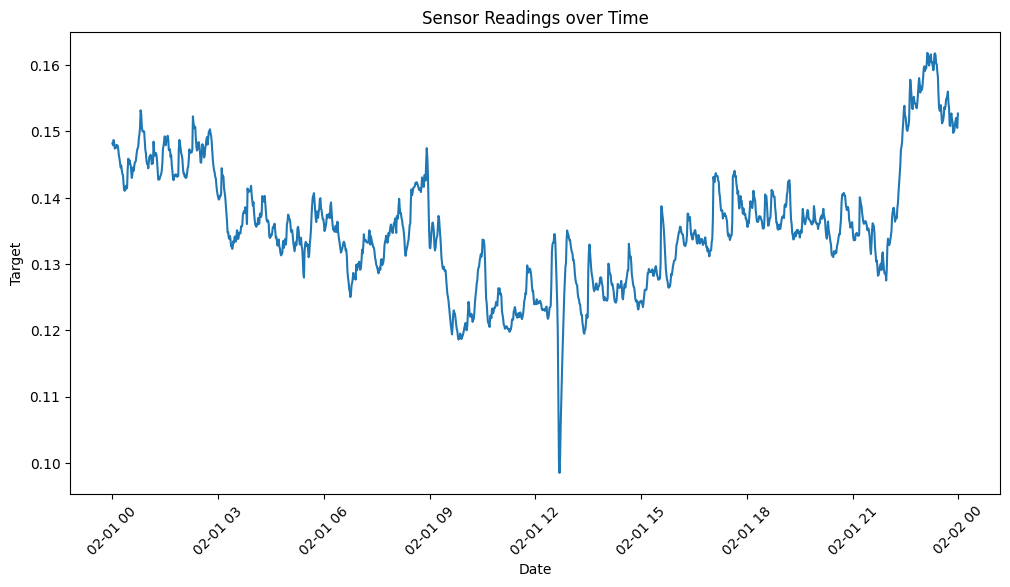

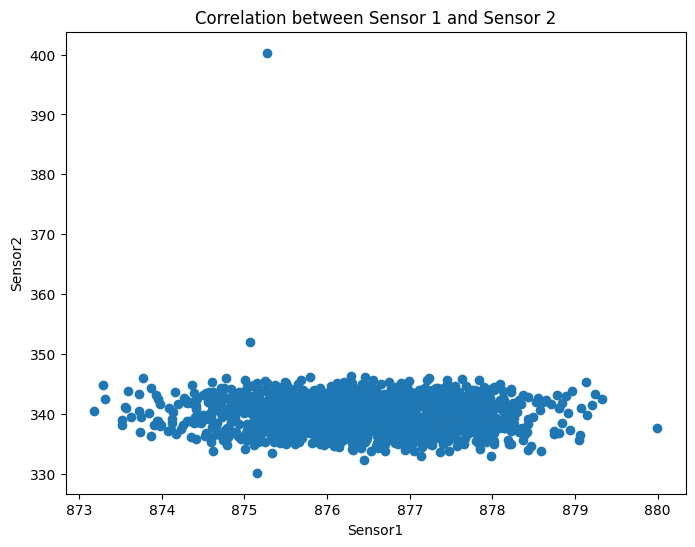

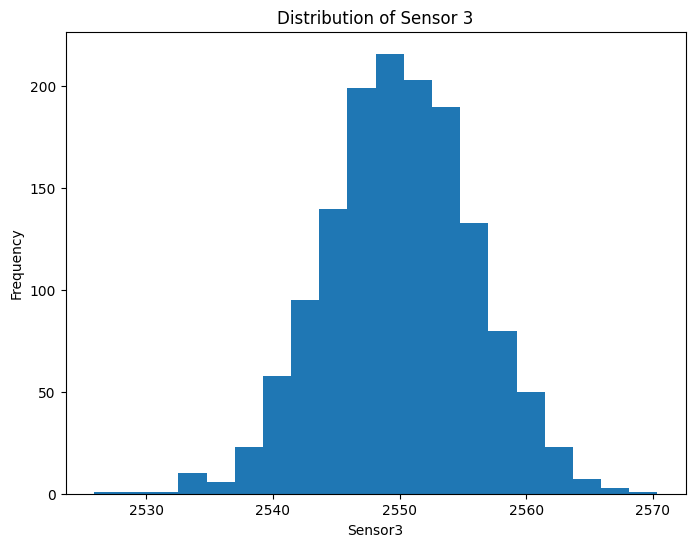

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date/Time'], data['target'])
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Sensor Readings over Time')
plt.xticks(rotation=45)
plt.show()

# Scatter plot to explore correlations between sensors
plt.figure(figsize=(8, 6))
plt.scatter(data['sensor1'], data['sensor2'])
plt.xlabel('Sensor1')
plt.ylabel('Sensor2')
plt.title('Correlation between Sensor 1 and Sensor 2')
plt.show()

# Histogram of a sensor reading
plt.figure(figsize=(8, 6))
plt.hist(data['sensor3'], bins=20)
plt.xlabel('Sensor3')
plt.ylabel('Frequency')
plt.title('Distribution of Sensor 3')
plt.show()


In [12]:
corr = data.groupby(by='target').agg('mean')[['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                                                 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11',
                                                 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17',
                                                 'sensor18', 'sensor19', 'sensor20', 'sensor21', 'sensor22', 'sensor23',
                                                 'sensor24', 'sensor25', 'sensor26', 'sensor27', 'sensor28', 'sensor29',
                                                 'sensor30', 'sensor31', 'sensor32', 'sensor33', 'sensor34', 'sensor35']].corr()

corr.style.background_gradient(cmap='coolwarm')


,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,sensor26,sensor27,sensor28,sensor29,sensor30,sensor31,sensor32,sensor33,sensor34,sensor35
sensor1,1.000000,-0.036589,-0.045207,0.211974,-0.009190,-0.004522,0.032992,-0.027937,-0.059958,-0.031238,0.485020,-0.119055,-0.127450,-0.166899,0.010623,-0.008663,-0.023299,-0.048103,-0.029051,-0.024423,0.032702,0.012757,-0.048664,0.086484,-0.016298,-0.000158,-0.057056,0.046827,0.007776,-0.032693,0.231088,0.073288,-0.013649,0.010127,0.015011
sensor2,-0.036589,1.000000,-0.255784,0.010999,0.005854,0.047408,0.044931,0.037780,-0.004745,-0.019799,-0.079336,-0.007144,0.018044,0.038112,-0.003848,0.036833,0.605777,0.039334,0.009904,0.014877,0.002581,-0.005675,0.024654,0.025981,0.031881,0.000386,-0.008508,-0.012434,0.015732,0.021468,0.009791,0.007808,0.037129,-0.014494,-0.034484
sensor3,-0.045207,-0.255784,1.000000,-0.069404,0.045450,0.105950,-0.016054,0.017620,-0.003086,-0.028828,-0.053283,0.040566,0.100381,0.308336,-0.012411,-0.025363,-0.439186,0.064133,0.018350,0.011023,0.014599,-0.011691,-0.016192,-0.039236,-0.015384,-0.097652,-0.326902,0.014088,-0.048177,-0.018668,-0.069202,0.041427,-0.002661,0.050373,0.022209
sensor4,0.211974,0.010999,-0.069404,1.000000,0.459466,0.651048,0.666877,0.619874,-0.320061,-0.664717,-0.175135,-0.706373,-0.064458,-0.263304,-0.443024,0.658261,-0.018723,0.638323,0.531995,0.650018,0.390308,-0.371411,-0.120572,0.471326,0.723176,0.042700,-0.241331,-0.099610,-0.291711,0.532931,0.998106,0.454668,0.354889,0.168046,-0.211247
sensor5,-0.009190,0.005854,0.045450,0.459466,1.000000,0.714434,0.765587,0.790778,-0.185231,-0.309015,-0.044292,-0.385793,-0.112824,-0.081109,-0.390698,0.248221,-0.010899,0.705180,0.744396,0.692958,0.595363,-0.448778,-0.154114,0.535105,0.630180,0.002211,-0.134590,-0.064329,-0.169061,0.300987,0.457765,0.382523,0.174090,0.169375,-0.069210
sensor6,-0.004522,0.047408,0.105950,0.651048,0.714434,1.000000,0.858026,0.897387,-0.353271,-0.561037,-0.198041,-0.560057,-0.001971,-0.083144,-0.558707,0.623617,-0.010477,0.894003,0.751394,0.784242,0.589595,-0.559291,-0.129607,0.631079,0.808570,-0.089186,-0.292672,-0.079044,-0.193799,0.593868,0.639992,0.619059,0.374870,0.214821,-0.209349
sensor7,0.032992,0.044931,-0.016054,0.666877,0.765587,0.858026,1.000000,0.900676,-0.264705,-0.429973,-0.114378,-0.456597,-0.040944,-0.107793,-0.522185,0.656006,-0.009340,0.849473,0.797359,0.843127,0.681964,-0.582824,-0.075765,0.775582,0.901971,-0.009239,-0.226430,-0.063491,-0.142769,0.652839,0.661120,0.551014,0.460216,0.129708,-0.310901
sensor8,-0.027937,0.037780,0.017620,0.619874,0.790778,0.897387,0.900676,1.000000,-0.297603,-0.509516,-0.206786,-0.518430,-0.015914,-0.077844,-0.436201,0.538439,-0.013858,0.900423,0.746096,0.763493,0.562753,-0.500058,-0.147804,0.620946,0.789618,-0.001361,-0.180204,-0.089199,-0.117102,0.516000,0.611104,0.507810,0.315405,0.190437,-0.170823
sensor9,-0.059958,-0.004745,-0.003086,-0.320061,-0.185231,-0.353271,-0.264705,-0.297603,1.000000,0.711607,0.122208,0.506982,-0.291462,0.157122,0.650856,-0.408332,0.020059,-0.134982,-0.498367,-0.515188,-0.567227,0.490931,0.061847,-0.414230,-0.351570,-0.021011,0.153898,0.005915,0.122234,-0.344908,-0.326550,-0.716938,-0.169806,-0.501321,-0.063942
sensor10,-0.031238,-0.019799,-0.028828,-0.664717,-0.309015,-0.561037,-0.429973,-0.509516,0.711607,1.000000,0.303119,0.760013,-0.340665,0.180341,0.567603,-0.533014,0.013364,-0.477536,-0.492009,-0.582289,-0.369243,0.454637,0.330612,-0.289392,-0.550623,-0.048446,0.205828,0.080157,0.415526,-0.416605,-0.653448,-0.562649,-0.216081,-0.281206,0.059096


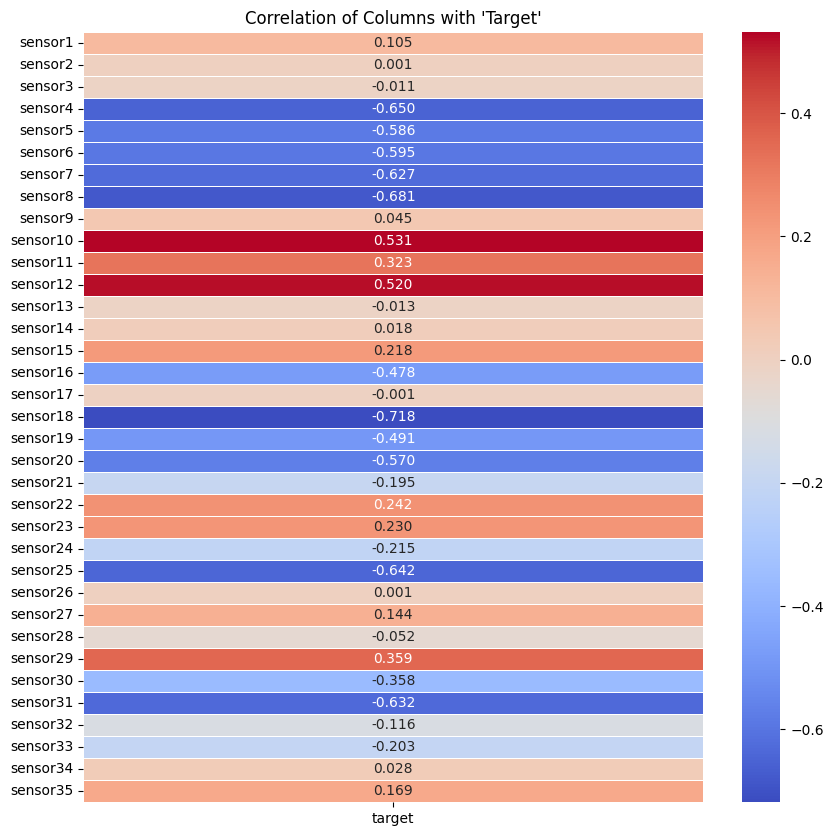

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
correlation_matrix = data.corr()
# Excluding 'f' column correlation with itself
target_corr = correlation_matrix['target'].drop('target')

sns.heatmap(target_corr.to_frame(), annot=True,
            linewidths=0.5, cmap='coolwarm', fmt='.3f', ax=ax)
plt.title("Correlation of Columns with 'Target'")
plt.show()


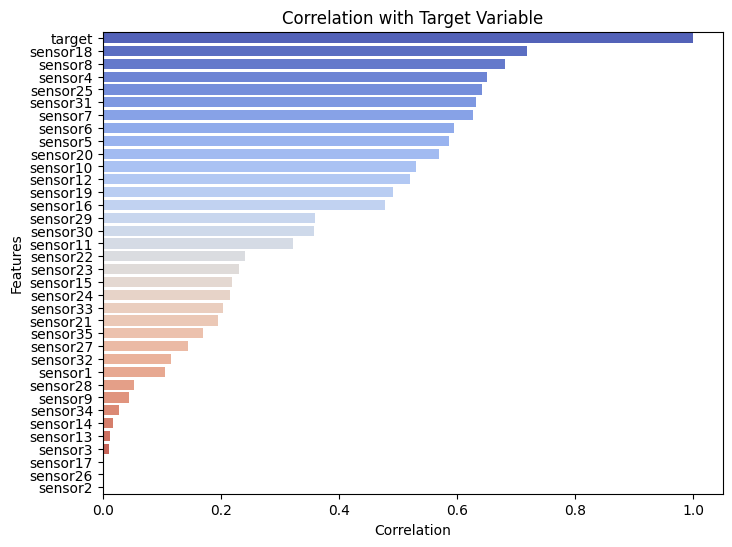

In [14]:
# Assuming your DataFrame is named 'data' and the target variable is named 'target'
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['target'].abs(
).sort_values(ascending=False)


# Plotting the correlation with the target variable
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_target.values,
            y=correlation_with_target.index, orient='h', palette='coolwarm')
plt.title('Correlation with Target Variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()


<h1>Analysis</h2>
Now Looking at this corelation matrix we will take the first top 20 columns for our model prediction because the rest of the columns are not too related to the target variable.

In [15]:
top_20_columns = correlation_with_target[:25].index.tolist()
print(top_20_columns)

['target', 'sensor18', 'sensor8', 'sensor4', 'sensor25', 'sensor31', 'sensor7', 'sensor6', 'sensor5', 'sensor20', 'sensor10', 'sensor12', 'sensor19', 'sensor16', 'sensor29', 'sensor30', 'sensor11', 'sensor22', 'sensor23', 'sensor15', 'sensor24', 'sensor33', 'sensor21', 'sensor35', 'sensor27']


# Modelling Data with Different Models

In [16]:
df = data_without_date.filter(items=top_20_columns)

In [17]:
target = df['target']
z_scores = np.abs((target - np.mean(target)) / np.std(target))
threshold = 4
filtered_target = target[(z_scores <= threshold)]
df['target'] = filtered_target
mean_value = df['target'].mean()
df['target'].fillna(mean_value, inplace=True)

In [18]:
from sklearn.preprocessing import StandardScaler

# Create the StandardScaler object
scaler = StandardScaler()
# Transform your data using the fitted scaler
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [19]:
x = df.drop(['target'], axis=1)
y = df['target']
predictModel = sm.OLS(y, sm.add_constant(x)).fit()
predictModel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     438.0
Date:                Mon, 17 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:16:41   Log-Likelihood:                -508.52
No. Observations:                1440   AIC:                             1067.
Df Residuals:                    1415   BIC:                             1199.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.979e-15      0.009  -1.09e-12      1.000      -0.018       0.018
sensor18       0.0274      0.034      0.810      0.418      -0.039       0.094
sensor8       -0.2053      0.036     -5.737      0.000      -0.275      -0.135
sensor4        0.2897      0.214      1.351      0.177      -0.131       0.710
sensor25      -0.0079      0.042     -0.190      0.850      -0.089       0.074
sensor31      -0.2825      0.207     -1.366      0.172      -0.688       0.123
sensor7       -0.1783      0.040     -4.456      0.000      -0.257      -0.100
sensor6        0.2499      0.031      8.099      0.000       0.189       0.310
sensor5       -0.3602      0.023    -15.344      0.000      -0.406      -0.314
sensor20      -1.9639      0.077    -25.671      0.000      -2.114      -1.814
sensor10       0.0371      0.019      1.937      0.053      -0.000       0.075
sensor12      -0.0413      0.018     -2.271      0.023      -0.077      -0.006
sensor19       0.6485      0.046     14.224      0.000       0.559       0.738
sensor16      -0.0721      0.025     -2.895      0.004      -0.121      -0.023
sensor29       0.0713      0.013      5.584      0.000       0.046       0.096
sensor30       0.0184      0.018      1.016      0.310      -0.017       0.054
sensor11       0.0365      0.012      3.172      0.002       0.014       0.059
sensor22      -0.0710      0.025     -2.807      0.005      -0.121      -0.021
sensor23       0.0671      0.016      4.149      0.000       0.035       0.099
sensor15      -0.0787      0.027     -2.926      0.003      -0.131      -0.026
sensor24       0.1735      0.022      7.968      0.000       0.131       0.216
sensor33       0.1857      0.041      4.528      0.000       0.105       0.266
sensor21       1.0266      0.036     28.809      0.000       0.957       1.096
sensor35       0.0871      0.039      2.259      0.024       0.011       0.163
sensor27       0.0453      0.010      4.485      0.000       0.025       0.065
==============================================================================
Omnibus:                      160.678   Durbin-Watson:                   0.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1324.662
Skew:                          -0.113   Prob(JB):                    2.26e-288
Kurtosis:                       7.693   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

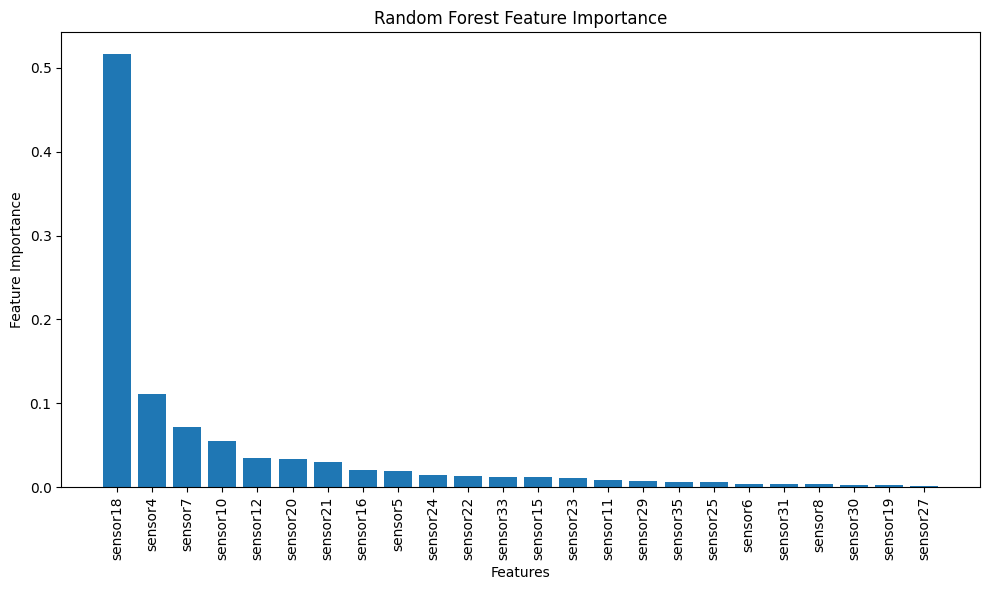

Mean Squared Error: 0.0580500116622435
Root Mean Squared Error: 0.24093570026511948
R-squared: 0.9365275788117311


In [20]:
X = df.drop(['target'], axis=1)  # Input features (sensor readings)
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100)
model = RandomForestRegressor()
model.fit(x_train, y_train)


y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)),
        sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)),
           sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


<h2>Random Forest OPTUNA study</h2>

In [21]:
# def objective(trial):

#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#     }

#     rf = RandomForestRegressor(**params)
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_valid)
#     mse = mean_squared_error(y_valid, y_pred)

#     return mse


# # Split the data into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X, y, test_size=0.2, random_state=42)
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Create the final Random Forest regressor with the best hyperparameters
# rf_best = RandomForestRegressor(**best_params)

# rf_best.fit(X_train, y_train)
# y_pred_test = rf_best.predict(X_test)


<h2> Decission Tree </h2>

In [22]:
X = df.drop(['target'], axis=1)
Y = df['target']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=99)

In [23]:
dt = DecisionTreeRegressor(random_state=99)
dtmodelTrain = dt.fit(X_train, y_train)
y_pred = dtmodelTrain.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 0.08349389940888081
Root Mean Squared Error: 0.28895310936011886
R-squared: 0.9162469177818164
Mean Absolute Percentage Error (MAPE): 1.0396126784714266


<h2>XG Boost</h2>

In [24]:
xgboost_model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7,
                                     eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error: 0.03896155096062376
Root Mean Squared Error: 0.19738680543699916
R-squared: 0.9609175041044258
Mean Absolute Percentage Error (MAPE): 0.5551181900391717


In [25]:
# def objective(trial):
#     # Define the hyperparameters to tune
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "eta": trial.suggest_float("eta", 0.1, 0.9, step=0.1),
#         "subsample": trial.suggest_float("subsample", 0.7, 0.9, step=0.1)


#     }

#     # Create a Random Forest regressor with the suggested hyperparameters
#     rf = xgboost.XGBRegressor(**params)

#     # Fit the model on the training data
#     rf.fit(X_train, y_train)

#     # Make predictions on the validation set
#     y_pred = rf.predict(X_valid)

#     # Calculate mean squared error as the evaluation metric
#     mse = mean_squared_error(y_valid, y_pred)

#     return mse


# # Split the data into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X, y, test_size=0.2, random_state=42)

# # Create an Optuna study and optimize the objective function
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=5)

# # Get the best hyperparameters found by Optuna
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# # Create the final Random Forest regressor with the best hyperparameters
# rf_best = xgboost.XGBRegressor(**best_params)

# # Fit the final model on the entire training set
# rf_best.fit(X_train, y_train)

# # Make predictions on the test set using the final model
# y_pred_test = rf_best.predict(X_test)


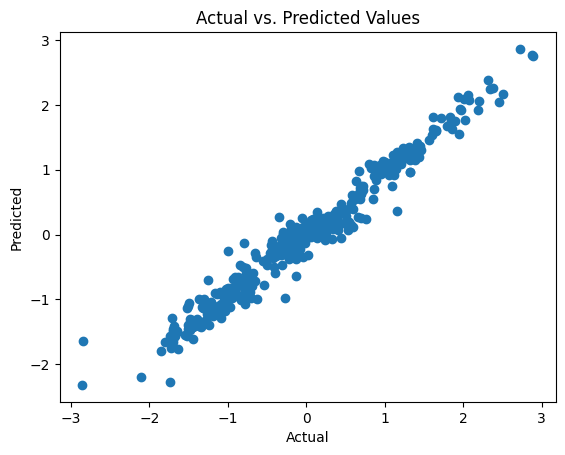

In [26]:
model = xgboost.XGBRegressor(
    n_estimators=400, max_depth=10, eta=0.1, subsample=0.8999999, colsample_bytree=0.8)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


<h2> CATBOOST </h2>

<h2> CATBOOST OPTUNA </h2>

In [27]:
# # Define the objective function for Optuna
# def objective(trial):
#     # Load your dataset and split it into training and validation sets


#     # Define the hyperparameters to optimize
#     params = {
#         'iterations': trial.suggest_int('iterations', 50, 200),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
#         'depth': trial.suggest_int('depth', 4, 10),
#     }

#     # Create the CatBoost regressor
#     model = cb.CatBoostRegressor(**params, loss_function='RMSE', verbose=False)

#     # Fit the model on the training data
#     model.fit(X_train, y_train)

#     # Predict on the validation data
#     y_pred = model.predict(X_test)

#     # Calculate the root mean squared error
#     rmse = mean_squared_error(y_test, y_pred, squared=False)

#     return rmse

# # Create an Optuna study
# study = optuna.create_study(direction='minimize')

# # Start the optimization process
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters and score
# best_params = study.best_params
# best_score = study.best_value

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Score:", best_score)


In [28]:
model = cb.CatBoostRegressor(
    iterations=200, learning_rate=0.09397, depth=10, loss_function='RMSE', verbose=False)

model.fit(X_train, y_train, verbose=False)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Squared Error: 0.22021349550766778
Mean Absolute Percentage Error (MAPE): 0.6838240399645239


<h2> LIGHTGBM </h2>

In [29]:
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Squared Error: 0.22139246803741355
Mean Absolute Percentage Error (MAPE): 0.6603982138922865


In [30]:
X = df.drop(['target'], axis=1)
y = df['target']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


<h3>Lasso Regressor and Ridge Regressor</h3>

In [31]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load your dataset and split it into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features using StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Create and fit the Ridge regression model
ridge = Ridge(alpha=1.0)  # You can adjust the value of alpha
ridge.fit(X_train, y_train)

# Create and fit the Lasso regression model
lasso = Lasso(alpha=1.0)  # You can adjust the value of alpha
lasso.fit(X_train, y_train)

# Predict on the test data using the Ridge model
y_pred_ridge = ridge.predict(X_test)

# Predict on the test data using the Lasso model
y_pred_lasso = lasso.predict(X_test)

# Calculate and print the RMSE for each model
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
print("Ridge RMSE:", rmse_ridge)
print("Lasso RMSE:", rmse_lasso)


Ridge RMSE: 0.3518451060318417
Lasso RMSE: 0.9972100219800201


<h2>LAZY PREDICT</h2>

In [32]:


reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)


 74%|███████▍  | 31/42 [03:40<01:18,  7.11s/it]


KeyboardInterrupt: ignored

In [33]:
X = df.drop('target', axis=1)  # Input features (sensor readings)
y = df['target']
model = ExtraTreesRegressor()
model.fit(X, y)

# Investigate feature importances
feature_importances = model.feature_importances_
print("Feature Importances:", feature_importances)


Feature Importances: [0.10592184 0.08459922 0.10713524 0.0775174  0.07995137 0.08701736
 0.01537975 0.08777223 0.04422064 0.04968195 0.05036866 0.00803047
 0.03014384 0.01054437 0.00484133 0.01693723 0.01902837 0.0075503
 0.02419162 0.01111727 0.02378125 0.03903342 0.01377483 0.00146002]


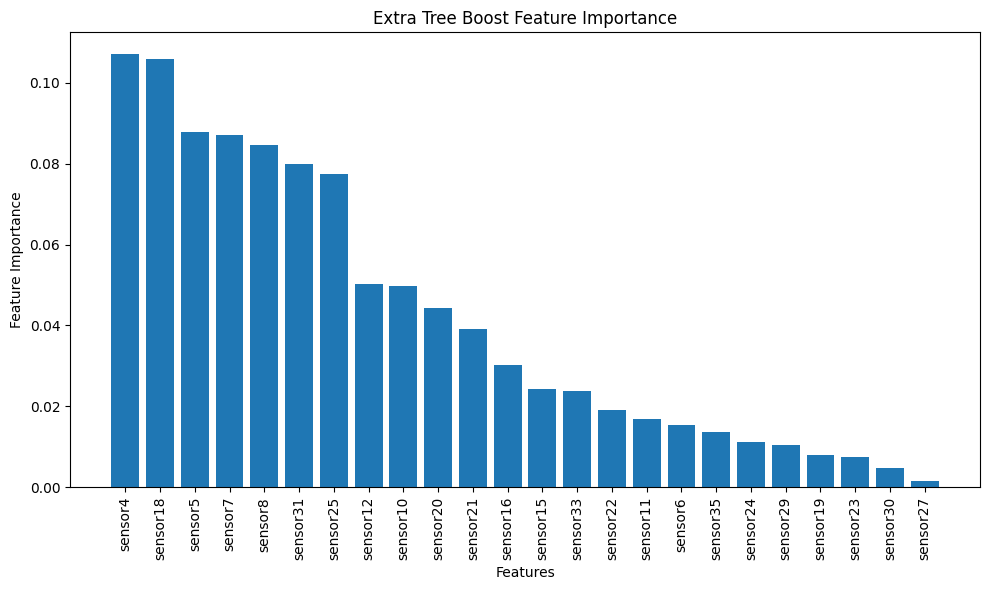

In [34]:
# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Extract the names of the features in the sorted order
sorted_feature_names = X.columns[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)),
        sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)),
           sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Extra Tree Boost Feature Importance')
plt.tight_layout()
plt.show()


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100)
model = ExtraTreesRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


RMSE: 0.1894585930300273
Mean Absolute Percentage Error (MAPE): 0.6089791057619723


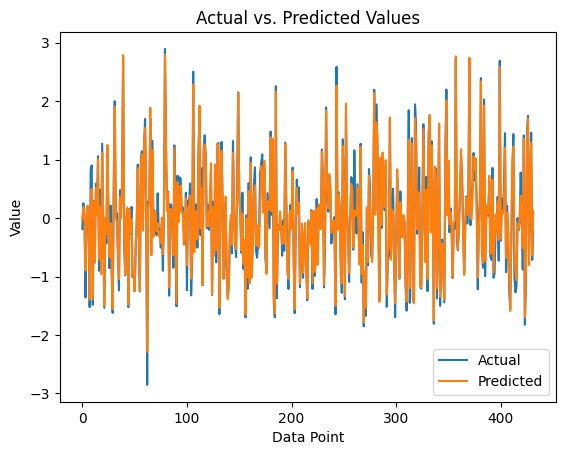

In [36]:
# Create a line chart for actual vs. predicted values
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


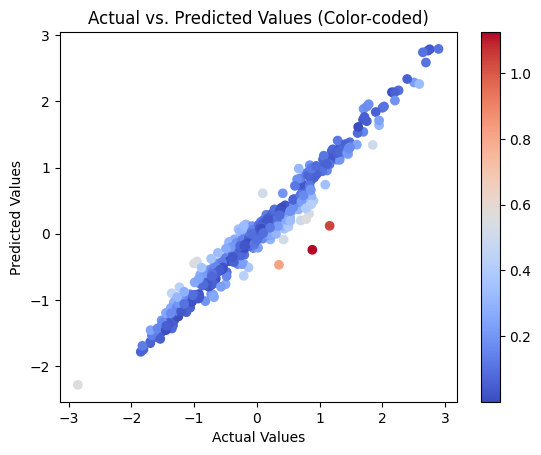

In [37]:
abs_diff = np.abs(y_pred - y_test)
cmap = plt.get_cmap("coolwarm")
plt.scatter(y_test, y_pred, c=abs_diff, cmap=cmap)
plt.colorbar()  # Add colorbar
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Color-coded)")
plt.show()


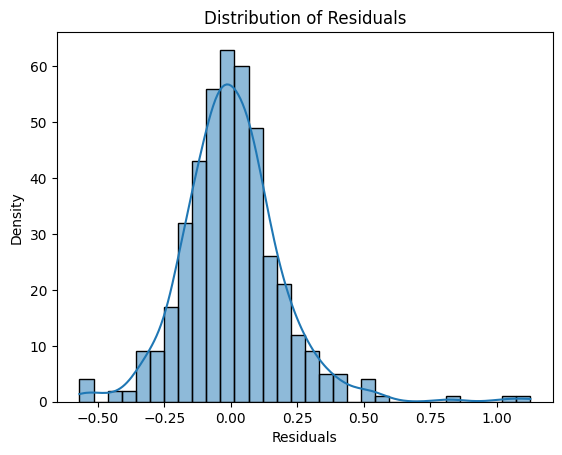

In [38]:
# Calculate residuals
residuals = y_test - y_pred

# Plot distribution of residuals
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Distribution of Residuals")
plt.show()
